# This is the script for combined data performance

In [1]:
import os
import pandas as pd
import numpy as np
import itertools 
import tqdm
import random
import json
import re
import nltk
from time import sleep
import matplotlib.pyplot as plt

# Algorithm package
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

# Utilities
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
# from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
import warnings 
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
df_raw = pd.read_json("Data/PreparedData.json", lines=True)

In [4]:
df_raw

,Unnamed: 0,IAPTus_Num_x,Referral Date,Age_ReferralRequest_ReceivedDate,EthnicDescGroupCode,EthnicCategoryGroupShortCode,GenderIdentity,SexualOrientationDesc,EndDesc,EndDescGroupShort,...,Item222,Item223,Item224,Item225,patient,round,IAPTus_Num_y,path,text,summarization
0,1,24475,1.536365e+12,5.099020,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,24475,0,NaN,None,None,None
1,2,244761,1.554854e+12,4.358899,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,24476,1,NaN,None,None,None
2,3,244762,1.616890e+12,4.582576,1.0,1.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,0.0,0.0,0.0,0.0,24476,2,NaN,None,None,None
3,4,24479,1.555373e+12,4.898979,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,24479,0,NaN,None,None,None
4,5,24482,1.536278e+12,0.000000,2.0,2.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,NaN,NaN,NaN,NaN,24482,0,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,724,24706,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,24706,0,NaN,None,None,None
724,725,24721,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,24721,0,NaN,None,None,None
725,727,24744,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,24744,0,NaN,None,None,None
726,730,24658,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,24658,0,NaN,None,None,None


# Label Preparing

## Recovery

In [5]:
df = df_raw[df_raw["RecoveryDesc"] == df_raw["RecoveryDesc"]]
df = df[(df["RecoveryDesc"].isin(["At recovery", "Not at recovery"]))]
df.reset_index().drop("index", axis=1)
print(df.shape)

labelList = []
for idx, row in df.iterrows():
    if (row["ReliableChangeDesc"] == "Reliable improvement") & (row["ReliableRecoveryDesc"] == "Reliable recovery") & (row["RecoveryDesc"] == "At recovery"):
        labelList.append(1)
    else:
        labelList.append(0)
df["label"] = labelList
labelList = ["label"]

(391, 285)


# Extra feature Preparation

In [6]:
def tokenize(text, doPreprocessing=True, doLemma=True):
    if doPreprocessing:
        text = " ".join(re.sub(r'[^\w\s]', ' ', text).replace("\n", " ").split())
    # tokens = [x for x in nltk.word_tokenize(text)]
    #print(text)
    tokens = text.split()
    # print(tokens)
    if doLemma:
        # stemmer = SnowballStemmer("english")
        lemma = nltk.wordnet.WordNetLemmatizer()
        tokens = [lemma.lemmatize(item) for item in tokens]
    return tokens

In [7]:
def genTFIDFFeat(df, param):
    df_corpus = df[df["summarization"] == df["summarization"]][["patient","round","text","summarization"]]
    df_corpus = df_corpus.reset_index().drop("index", axis=1)
    vectorizer_tfidf = TfidfVectorizer(
        tokenizer=tokenize,
        stop_words="english",
        max_features=param["max_features"], 
        ngram_range=param["ngram_range"]
    )
    feat = vectorizer_tfidf.fit_transform(df_corpus["summarization"])
    featCol = ["Tfidf" + str(i) for i in range(feat.shape[1])]
    df_tfidf = pd.DataFrame(feat.toarray(), columns=featCol)
    df_final = pd.concat([df_corpus, df_tfidf], axis=1)
    df_result = pd.merge(df, df_final, on=["patient","round"], how="left")
    return df_result

In [8]:
param_dict = {
    "max_features": 50,
    "ngram_range": (1,3),
}

In [9]:
genTFIDFFeat(df_raw, param_dict)

,Unnamed: 0,IAPTus_Num_x,Referral Date,Age_ReferralRequest_ReceivedDate,EthnicDescGroupCode,EthnicCategoryGroupShortCode,GenderIdentity,SexualOrientationDesc,EndDesc,EndDescGroupShort,...,Tfidf40,Tfidf41,Tfidf42,Tfidf43,Tfidf44,Tfidf45,Tfidf46,Tfidf47,Tfidf48,Tfidf49
0,1,24475,1.536365e+12,5.099020,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,244761,1.554854e+12,4.358899,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,244762,1.616890e+12,4.582576,1.0,1.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,24479,1.555373e+12,4.898979,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,24482,1.536278e+12,0.000000,2.0,2.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,724,24706,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
724,725,24721,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,727,24744,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,730,24658,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training Utility Function

In [10]:
def SingleModelPlot(resultList, modelName):
    df = pd.DataFrame(resultList)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    values = df.values
    columns = df.columns.tolist()
    axs.violinplot(values,
                  showmeans=False,
                  showmedians=True)
    axs.set_title('Violin plot')

    axs.yaxis.grid(True)
    axs.set_xticks([y + 1 for y in range(len(columns))],
                  labels=columns)
    axs.set_xlabel(modelName)
    axs.set_ylabel('Observed values')

    print("Model: {}\nAccuracy mean: {:.4f}, Precision mean: {:.4f}, Recall Mean: {:.4f}, F1 Mean: {:.4f}".format(
                                                                                                                    modelName,
                                                                                                                    np.mean(df["Accuracy"]), 
                                                                                                                    np.mean(df["Precision"]),
                                                                                                                    np.mean(df["Recall"]),
                                                                                                                    np.mean(df["F1"]),
                                                                                                                )
         )

In [11]:
# mannually generate the search grid
def makeGrid(pars_dict):  
    keys=pars_dict.keys()
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds

In [12]:
def MyGridSearch(model, model_param, param_dict, df_raw, labelList):    
    searchSpace = makeGrid(param_dict)
    print("Search Space Size:" + len(searchSpace).__str__())
    resultList = []
    for param in tqdm.tqdm(searchSpace):
        df = genTFIDFFeat(df_raw, param)
        # prepare the feature list
        colnames = []
        for item in df.columns:
            if item.startswith("Item") or item.startswith("Tfidf") or item.startswith("Topic"):
                colnames.append(item)
        #sleep(1)
        clf = model(**model_param)
        # scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy", n_jobs=5)
        f1List = []
        skf = StratifiedKFold(n_splits=5)
        for i, (train_index, val_index) in enumerate(skf.split(df[colnames], df[labelList])):
            (X_train, Y_train) = df.iloc[train_index][colnames], df.iloc[train_index][labelList]
            (X_val, Y_val) = df.iloc[val_index][colnames], df.iloc[val_index][labelList]
            clf.fit(X_train, Y_train.values.ravel())
            predicted_val = clf.predict(X_val)
            predicted_val = (predicted_val > 0.5)
            f1 = f1_score(Y_val[labelList], predicted_val)
            f1List.append(f1)
        
        result = {}
        result["f1_mean"] = np.mean(f1List)
        result["f1_std"] = np.std(f1List)
        result["f1"] = f1List
        result["param"] = param
        resultList.append(result)
    sortedResult = sorted(resultList, key=lambda x: x["f1_mean"], reverse=True)
    print(sortedResult[:5])
    return sortedResult

In [13]:
def gen100Prediction(model, model_param, searchResult, df, labelList):
    AccList = []
    for i in range(100):
        param = searchResult[0]["param"]
        df_new = genTFIDFFeat(df, param)
        colnames = []
        for item in df_new.columns:
            if item.startswith("Item") or item.startswith("Tfidf") or item.startswith("Topic"):
                colnames.append(item)

        # Keep 10% data as the test data
        train, test = train_test_split(df_new, test_size=0.1)
        # train.shape

        clf = model(**model_param)
        clf = clf.fit(train[colnames],train[labelList].values.ravel())

        predicted_test = clf.predict(test[colnames])
        accuracy_score, precision_score, recall_score, f1_score
        result = {}
        result["Accuracy"] = accuracy_score(test[labelList], (predicted_test>0.5))
        result["Precision"] = precision_score(test[labelList], (predicted_test>0.5), average="macro")
        result["Recall"] = recall_score(test[labelList], (predicted_test>0.5), average="macro")
        result["F1"] = f1_score(test[labelList], (predicted_test>0.5), average="macro")  
        AccList.append(result)
    print(AccList)
    return AccList

# TFIDF hyper param search space

In [14]:
param_dict = {
    "max_features": [x*10 for x in range(1, 100)],
    "ngram_range": [(1,1),(1,2),(2,2),(1,3),(2,3),(3,3),(1,4),(2,4),(3,4),(4,4)]    
}

# DT

In [15]:
model_param = {
    'criterion': 'log_loss', 
    'max_depth': None, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'min_weight_fraction_leaf': 0.0, 
    'max_features': None, 
    'max_leaf_nodes': None
}

In [16]:
searchResult = MyGridSearch(tree.DecisionTreeClassifier, model_param, param_dict, df, labelList)

Search Space Size:990


100%|██████████| 990/990 [06:37<00:00,  2.49it/s]

[{'f1_mean': 0.5939833804271868, 'f1_std': 0.04725967707092181, 'f1': [0.6037735849056604, 0.5925925925925926, 0.675, 0.5652173913043478, 0.5333333333333333], 'param': {'max_features': 560, 'ngram_range': (2, 4)}}, {'f1_mean': 0.5691985227909554, 'f1_std': 0.01491281822484971, 'f1': [0.5531914893617021, 0.55, 0.575, 0.5806451612903226, 0.5871559633027523], 'param': {'max_features': 100, 'ngram_range': (2, 3)}}, {'f1_mean': 0.5678720710299657, 'f1_std': 0.06757064480896487, 'f1': [0.631578947368421, 0.4642857142857143, 0.5142857142857142, 0.5945945945945946, 0.6346153846153846], 'param': {'max_features': 790, 'ngram_range': (2, 3)}}, {'f1_mean': 0.5643694363934052, 'f1_std': 0.0913293968028533, 'f1': [0.5871559633027523, 0.627906976744186, 0.6336633663366337, 0.5871559633027523, 0.38596491228070173], 'param': {'max_features': 710, 'ngram_range': (2, 3)}}, {'f1_mean': 0.563168495349502, 'f1_std': 0.05386318874078258, 'f1': [0.6, 0.4857142857142857, 0.5393258426966292, 0.6428571428571429,

In [17]:
DTAccList = gen100Prediction(tree.DecisionTreeClassifier, model_param, searchResult, df, labelList)

[{'Accuracy': 0.5, 'Precision': 0.5050505050505051, 'Recall': 0.5050505050505051, 'F1': 0.5}, {'Accuracy': 0.475, 'Precision': 0.2375, 'Recall': 0.5, 'F1': 0.3220338983050847}, {'Accuracy': 0.475, 'Precision': 0.47333333333333333, 'Recall': 0.475, 'F1': 0.4666666666666667}, {'Accuracy': 0.525, 'Precision': 0.5416666666666666, 'Recall': 0.540920716112532, 'F1': 0.5247029393370857}, {'Accuracy': 0.525, 'Precision': 0.6541218637992832, 'Recall': 0.6181318681318682, 'F1': 0.5174603174603174}, {'Accuracy': 0.425, 'Precision': 0.4273182957393483, 'Recall': 0.4267676767676768, 'F1': 0.42464040025015637}, {'Accuracy': 0.5, 'Precision': 0.48589341692789967, 'Recall': 0.4887218045112782, 'F1': 0.4666666666666667}, {'Accuracy': 0.575, 'Precision': 0.5767263427109974, 'Recall': 0.575, 'F1': 0.5725958516656191}, {'Accuracy': 0.6, 'Precision': 0.3076923076923077, 'Recall': 0.48, 'F1': 0.375}, {'Accuracy': 0.55, 'Precision': 0.46394984326018807, 'Recall': 0.4672364672364673, 'F1': 0.4642857142857143}

Model: Decision Tree
Accuracy mean: 0.5202, Precision mean: 0.4755, Recall Mean: 0.5034, F1 Mean: 0.4553


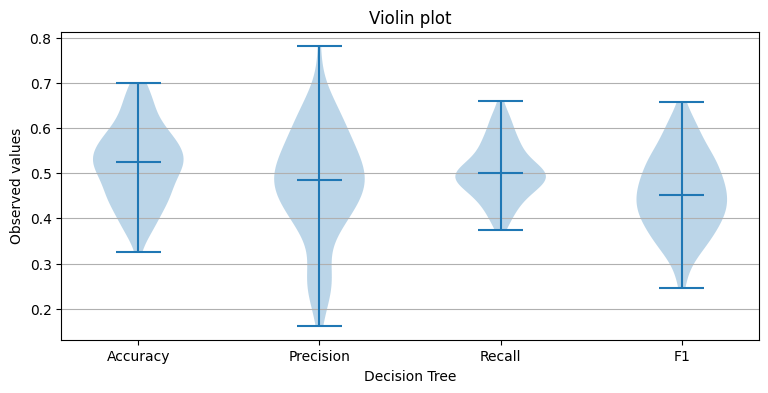

In [18]:
SingleModelPlot(DTAccList, "Decision Tree")

# Random Forest

In [19]:
model_param = {
    'n_estimators': 50, 
    'criterion': 'gini', 
    'max_depth': 16, 
    'max_features': 'sqrt', 
    'max_leaf_nodes': 40, 
    'max_samples': 0.5, 
    'random_state': 9648, 
    'n_jobs': -1
}

In [20]:
searchResult = MyGridSearch(RandomForestClassifier, model_param, param_dict, df, labelList)

Search Space Size:990


100%|██████████| 990/990 [07:10<00:00,  2.30it/s]

[{'f1_mean': 0.3709578376007457, 'f1_std': 0.10695971210521064, 'f1': [0.32786885245901637, 0.23076923076923078, 0.4918032786885246, 0.5, 0.30434782608695654], 'param': {'max_features': 30, 'ngram_range': (2, 4)}}, {'f1_mean': 0.36409129125311873, 'f1_std': 0.141767832216902, 'f1': [0.3225806451612903, 0.21818181818181817, 0.30434782608695654, 0.6349206349206349, 0.3404255319148936], 'param': {'max_features': 110, 'ngram_range': (1, 3)}}, {'f1_mean': 0.36047459263565496, 'f1_std': 0.07043310873312111, 'f1': [0.35555555555555557, 0.27586206896551724, 0.34782608695652173, 0.4897959183673469, 0.3333333333333333], 'param': {'max_features': 90, 'ngram_range': (3, 4)}}, {'f1_mean': 0.3571714902427206, 'f1_std': 0.08414980172443194, 'f1': [0.2553191489361702, 0.3333333333333333, 0.5, 0.30434782608695654, 0.39285714285714285], 'param': {'max_features': 50, 'ngram_range': (4, 4)}}, {'f1_mean': 0.3533132519433889, 'f1_std': 0.09926045490160125, 'f1': [0.18181818181818182, 0.410958904109589, 0.34

In [21]:
RFAccList = gen100Prediction(RandomForestClassifier, model_param, searchResult, df, labelList)

[{'Accuracy': 0.45, 'Precision': 0.2571428571428571, 'Recall': 0.391304347826087, 'F1': 0.3103448275862069}, {'Accuracy': 0.575, 'Precision': 0.5173160173160173, 'Recall': 0.5104166666666667, 'F1': 0.4813119755911518}, {'Accuracy': 0.625, 'Precision': 0.6397849462365591, 'Recall': 0.5984848484848485, 'F1': 0.5807127882599581}, {'Accuracy': 0.5, 'Precision': 0.7142857142857143, 'Recall': 0.6, 'F1': 0.4666666666666667}, {'Accuracy': 0.625, 'Precision': 0.6130952380952381, 'Recall': 0.5971867007672634, 'F1': 0.5943204868154158}, {'Accuracy': 0.575, 'Precision': 0.5455840455840456, 'Recall': 0.5416666666666667, 'F1': 0.5402298850574713}, {'Accuracy': 0.525, 'Precision': 0.7564102564102564, 'Recall': 0.525, 'F1': 0.38660209846650523}, {'Accuracy': 0.625, 'Precision': 0.5826210826210827, 'Recall': 0.5796703296703296, 'F1': 0.5807127882599581}, {'Accuracy': 0.525, 'Precision': 0.4175627240143369, 'Recall': 0.4368131868131868, 'F1': 0.42028985507246375}, {'Accuracy': 0.675, 'Precision': 0.6562

Model: Random Forest
Accuracy mean: 0.5548, Precision mean: 0.5355, Recall Mean: 0.5205, F1 Mean: 0.4922


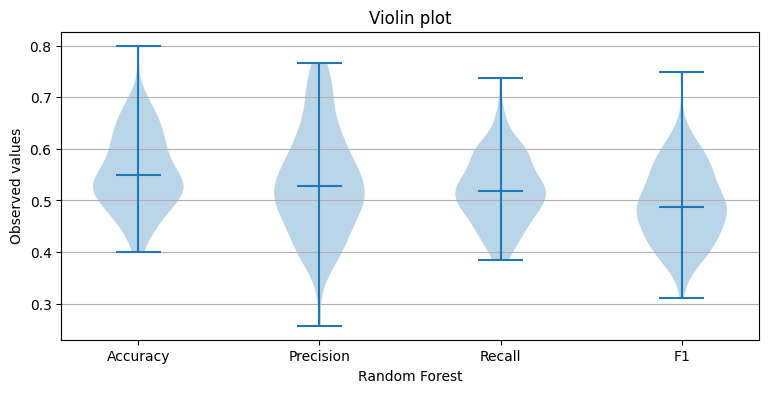

In [22]:
SingleModelPlot(RFAccList, "Random Forest")

# GBM

In [23]:
model_param = {
    'n_estimators': 100, 
    'max_depth': 8, 
    'min_child_samples': 10, 
    'num_leaves': 15, 
    'colsample_bytree': 1.0, 
    'subsample': 0.5, 
    'random_state': 15847, 
    'n_jobs': -1, 
    'verbose': -1
}

In [24]:
searchResult = MyGridSearch(LGBMClassifier, model_param, param_dict, df, labelList)

Search Space Size:990


100%|██████████| 990/990 [26:06<00:00,  1.58s/it]

[{'f1_mean': 0.43722941906460316, 'f1_std': 0.08759225875445581, 'f1': [0.3448275862068966, 0.31746031746031744, 0.5230769230769231, 0.5084745762711864, 0.49230769230769234], 'param': {'max_features': 770, 'ngram_range': (1, 2)}}, {'f1_mean': 0.4318789866958265, 'f1_std': 0.06760428853530275, 'f1': [0.3870967741935484, 0.3225806451612903, 0.4745762711864407, 0.5084745762711864, 0.4666666666666667], 'param': {'max_features': 590, 'ngram_range': (1, 2)}}, {'f1_mean': 0.43107852539683955, 'f1_std': 0.08402008427536303, 'f1': [0.41935483870967744, 0.29508196721311475, 0.4918032786885246, 0.5423728813559322, 0.4067796610169492], 'param': {'max_features': 920, 'ngram_range': (1, 3)}}, {'f1_mean': 0.4306148213949232, 'f1_std': 0.07097269549484699, 'f1': [0.3793103448275862, 0.32786885245901637, 0.4482758620689655, 0.5333333333333333, 0.4642857142857143], 'param': {'max_features': 490, 'ngram_range': (1, 4)}}, {'f1_mean': 0.42971972501322053, 'f1_std': 0.0798190735124134, 'f1': [0.393442622950

In [25]:
GBMAccList = gen100Prediction(LGBMClassifier, model_param, searchResult, df, labelList)

[{'Accuracy': 0.625, 'Precision': 0.6499999999999999, 'Recall': 0.612781954887218, 'F1': 0.5943204868154158}, {'Accuracy': 0.55, 'Precision': 0.484375, 'Recall': 0.4895833333333333, 'F1': 0.4642857142857143}, {'Accuracy': 0.475, 'Precision': 0.49145299145299143, 'Recall': 0.49242424242424243, 'F1': 0.4666666666666667}, {'Accuracy': 0.55, 'Precision': 0.5595238095238095, 'Recall': 0.55, 'F1': 0.53125}, {'Accuracy': 0.45, 'Precision': 0.46875, 'Recall': 0.46875, 'F1': 0.45}, {'Accuracy': 0.6, 'Precision': 0.6190476190476191, 'Recall': 0.6000000000000001, 'F1': 0.5833333333333333}, {'Accuracy': 0.525, 'Precision': 0.5085470085470085, 'Recall': 0.5075757575757576, 'F1': 0.49967083607636603}, {'Accuracy': 0.575, 'Precision': 0.5520833333333333, 'Recall': 0.5533333333333333, 'F1': 0.5523370638578011}, {'Accuracy': 0.5, 'Precision': 0.4700854700854701, 'Recall': 0.47314578005115093, 'F1': 0.4666666666666667}, {'Accuracy': 0.65, 'Precision': 0.5811965811965812, 'Recall': 0.5893416927899686, 'F

Model: GBM
Accuracy mean: 0.5440, Precision mean: 0.5202, Recall Mean: 0.5144, F1 Mean: 0.5014


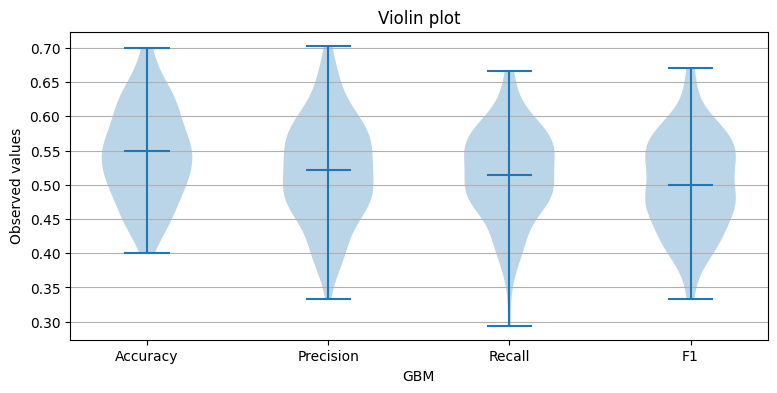

In [26]:
SingleModelPlot(GBMAccList, "GBM")

# XGBoost

In [27]:
model_param = {
    'n_estimators': 150, 
    'max_depth': 16, 
    'objective': 'binary:logistic', 
    'n_jobs': 5, 
    'subsample': 1.0, 
    'colsample_bytree': 1.0, 
    'colsample_bylevel': 0.7, 
    'colsample_bynode': 1.0, 
    'num_parallel_tree': 4
}

In [28]:
searchResult = MyGridSearch(xgb.XGBRegressor, model_param, param_dict, df, labelList)

Search Space Size:990


100%|██████████| 990/990 [1:06:18<00:00,  4.02s/it]

[{'f1_mean': 0.45271637581526525, 'f1_std': 0.06802784216207684, 'f1': [0.4262295081967213, 0.3548387096774194, 0.4918032786885246, 0.5573770491803278, 0.43333333333333335], 'param': {'max_features': 650, 'ngram_range': (2, 3)}}, {'f1_mean': 0.45266299467372273, 'f1_std': 0.07322639817905532, 'f1': [0.38596491228070173, 0.3448275862068966, 0.4918032786885246, 0.5245901639344263, 0.5161290322580645], 'param': {'max_features': 60, 'ngram_range': (2, 4)}}, {'f1_mean': 0.44615148292567647, 'f1_std': 0.0580125088637881, 'f1': [0.39285714285714285, 0.36666666666666664, 0.5230769230769231, 0.4838709677419355, 0.4642857142857143], 'param': {'max_features': 230, 'ngram_range': (2, 3)}}, {'f1_mean': 0.44485568760611205, 'f1_std': 0.06991612457221526, 'f1': [0.4, 0.3548387096774194, 0.5, 0.5483870967741935, 0.42105263157894735], 'param': {'max_features': 690, 'ngram_range': (2, 2)}}, {'f1_mean': 0.44304472397071215, 'f1_std': 0.06788657419319981, 'f1': [0.4406779661016949, 0.3157894736842105, 0.4

In [29]:
XGBAccList = gen100Prediction(xgb.XGBRegressor, model_param, searchResult, df, labelList)

[{'Accuracy': 0.6, 'Precision': 0.6098901098901099, 'Recall': 0.6, 'F1': 0.5907928388746804}, {'Accuracy': 0.5, 'Precision': 0.48028673835125446, 'Recall': 0.48621553884711777, 'F1': 0.45054945054945056}, {'Accuracy': 0.55, 'Precision': 0.5119047619047619, 'Recall': 0.5104166666666667, 'F1': 0.5054945054945055}, {'Accuracy': 0.55, 'Precision': 0.5333333333333333, 'Recall': 0.5319693094629157, 'F1': 0.53125}, {'Accuracy': 0.575, 'Precision': 0.5455840455840456, 'Recall': 0.5416666666666667, 'F1': 0.5402298850574713}, {'Accuracy': 0.325, 'Precision': 0.30877742946708464, 'Recall': 0.34595959595959597, 'F1': 0.3036750483558994}, {'Accuracy': 0.55, 'Precision': 0.5319693094629157, 'Recall': 0.5333333333333333, 'F1': 0.53125}, {'Accuracy': 0.55, 'Precision': 0.5388471177944862, 'Recall': 0.54858934169279, 'F1': 0.52}, {'Accuracy': 0.55, 'Precision': 0.5520833333333333, 'Recall': 0.55, 'F1': 0.5454545454545454}, {'Accuracy': 0.625, 'Precision': 0.6225071225071226, 'Recall': 0.608585858585858

Model: XGBoost
Accuracy mean: 0.5478, Precision mean: 0.5302, Recall Mean: 0.5268, F1 Mean: 0.5145


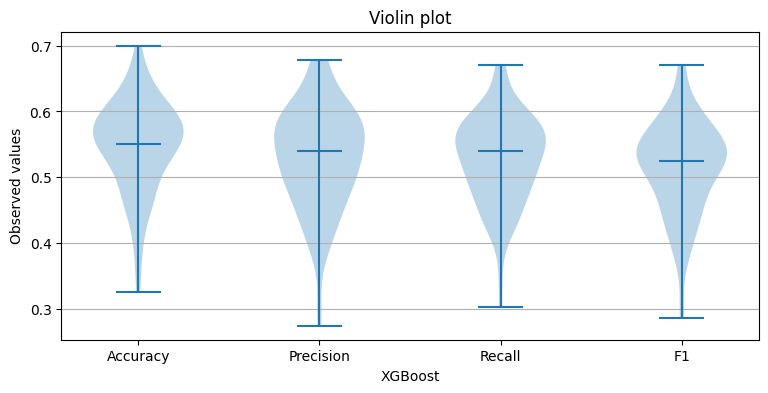

In [30]:
SingleModelPlot(XGBAccList, "XGBoost")

# Comparison

In [31]:
allResult = {}
allResult["Decision Tree"] = DTAccList
allResult["Random Forest"] = RFAccList
allResult["Light GBM"] = GBMAccList
allResult["XGBoost"] = XGBAccList

In [32]:
with open("Combined-ML-Recovery.json", "w") as writer:
    writer.write(json.dumps(allResult, ensure_ascii=False))

In [33]:
def PreAll(allResult):
    modelList = list(allResult.keys())
    accResult = {}
    preResult = {}
    recResult = {}
    f1Result = {}
    for model in modelList:
        accResult[model] = [x["Accuracy"] for x in allResult[model]]
        preResult[model] = [x["Precision"] for x in allResult[model]]
        recResult[model] = [x["Recall"] for x in allResult[model]]
        f1Result[model] = [x["F1"] for x in allResult[model]]
    return accResult, preResult, recResult, f1Result

def comPlot(Result, Name, ModelList):
    valueList = [Result[model] for model in ModelList]
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    axs.violinplot(valueList,
                  showmeans=False,
                  showmedians=True)
    axs.set_title('Violin plot')
    
    axs.yaxis.grid(True)
    axs.set_xticks([y + 1 for y in range(len(ModelList))],
                  labels=modelList)
    axs.set_xlabel(Name)
    axs.set_ylabel('Observed values')
    
    plt.show()    

In [34]:
accResult, preResult, recResult, f1Result = PreAll(allResult)

In [35]:
modelList = list(accResult.keys())

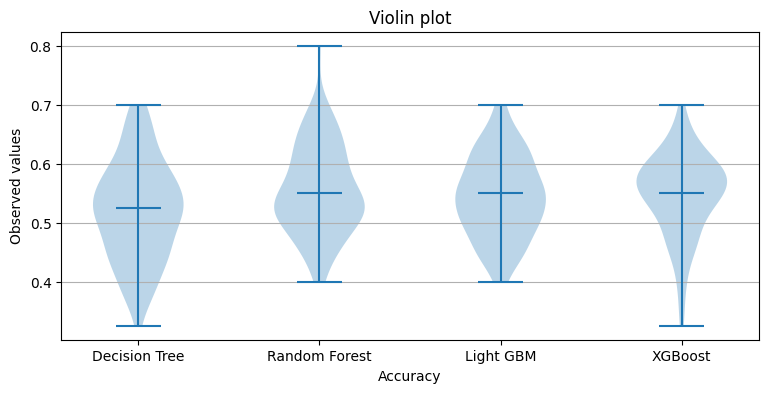

In [36]:
comPlot(accResult, "Accuracy", modelList)

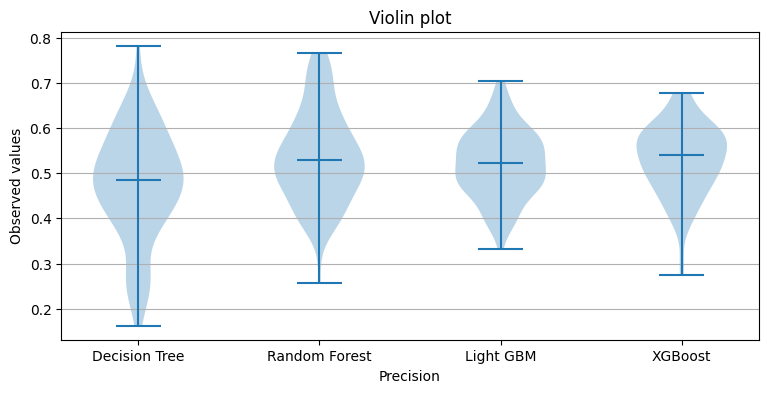

In [37]:
comPlot(preResult, "Precision", modelList)

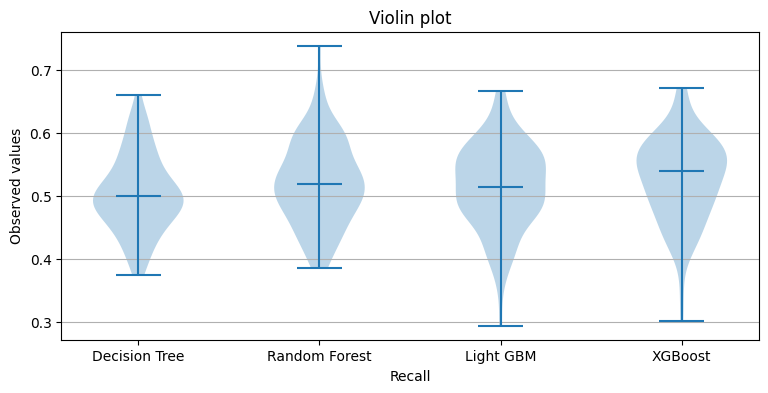

In [38]:
comPlot(recResult, "Recall", modelList)

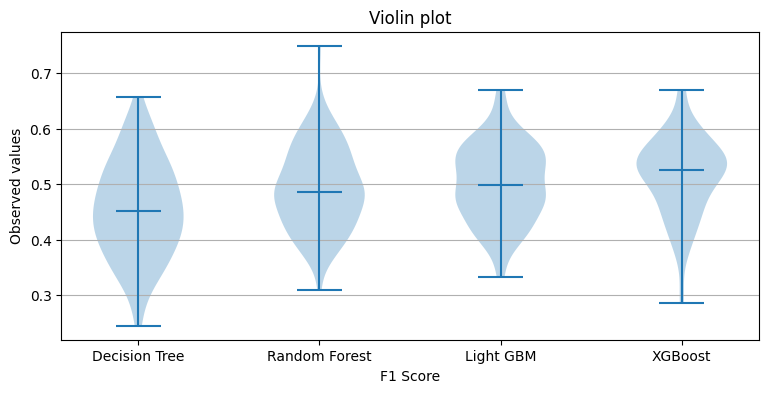

In [39]:
comPlot(f1Result, "F1 Score", modelList)